# Differential gene expression analysis per cell-type between conditions

In [1]:
#Load libraries
import pandas as pd
import numpy as np
import os
import subprocess as sp
import decoupler as dc
import scanpy as sc

# Libraries for visualization
from typing import Mapping, Optional, Sequence
import warnings
import scipy.stats
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import altair as alt
from itertools import zip_longest
import statsmodels.stats.multitest


# set PATH env variable to conda env for specific R version.
# To use [DESeq2, R version "4.2" required](https://bioconductor.org/packages/release/bioc/html/DESeq2.html)
path_to_R = "/usr/local/bioinf/R/R-4.2.3/bin/"
os.environ["PATH"] = path_to_R + os.pathsep + os.environ["PATH"]

cpus = 6

### Configure paths
    - adata_path: Path to anndata file
    - deseq: Path to deseq2 script 
    - deseq_results: Path to results directory. 


In [2]:
adata_path = "/data/projects/2023/atlas_protocol/input_data_zenodo/atlas-integrated-annotated.h5ad"
deseq = "../../bin/deseq2.R"
deseq_results = "/data/projects/2023/atlas_protocol/results/differential_expression/deseq_resdir"

### Load data

    anndata object

In [3]:
adata = sc.read_h5ad(adata_path)

#Subset adata
adata = adata[adata.obs["origin"].isin(["tumor_primary"])]
adata = adata[adata.obs["condition"].isin(["LUAD", "LUSC"])]

### Pseudobulk


#### Get pseudobulk for entire adata

In [4]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(adata,
                          sample_col='sample',
                          groups_col='condition',
                          layer='raw_counts', #layer where raw counts are store in adata
                          mode='sum',
                          min_cells=0,
                          min_counts=0
                         )
pdata

AnnData object with n_obs × n_vars = 22 × 17837
    obs: 'sample', 'uicc_stage', 'sex', 'ever_smoker', 'driver_genes', 'condition', 'age', 'patient', 'tissue', 'origin', 'dataset', 'doublet_status', 'total_counts_mito', 'pct_counts_mito', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'platform_fine', 'batch', '_predictions', '_leiden', '_cell_type_tumor_predicted', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'psbulk_props'

#### Quality control plot

From generated profile for each sample and condition

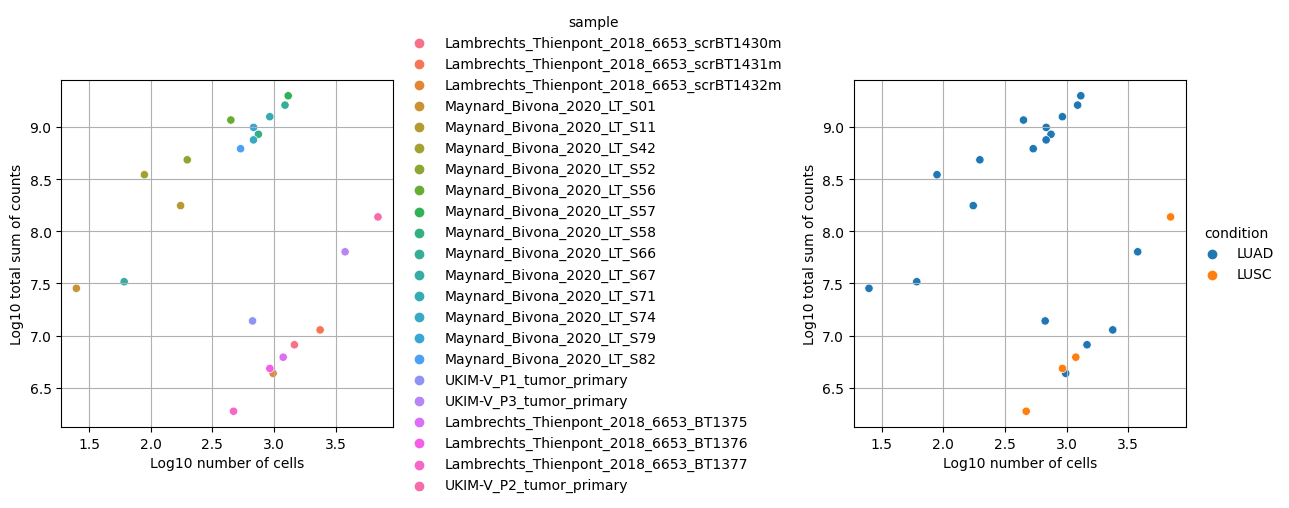

In [5]:
dc.plot_psbulk_samples(pdata, groupby=['sample','condition'], figsize=(13,5))

Convention to filter low quality samples:

    - Number of cells --> min_cells (genes  minimum total number of reads across sample)
    - Number of counts --> min_counts (genes minimum number of counts in a number of samples)
    
Check the frequency of genes (features) vs n. of samples and total sum of counts with  ```plot_filter_by_expr```


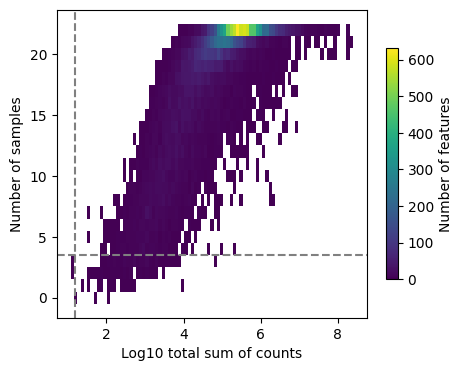

In [6]:
dc.plot_filter_by_expr(pdata, group='condition', min_count=10,min_total_count=15)

#### Define cell type to use

Specifiy for which cell type annotation level we want to run the differential expression analyses

In [7]:
cell_type = list(adata.obs["cell_type_coarse"].unique())

#### Create dictionary of adatas subsetted by cell type

In [8]:
adata_dict = {}
for name in cell_type:
    name_ad = name.replace(" ","_")
    adata_name = f"{name_ad}_adata"
    adata_dict[adata_name] = adata[adata.obs["cell_type_coarse"].isin([name])]

#### Function: Run DESeq2 on pseudobulk of all cell types from cell_type 

In [9]:
def run_deseq(count_table, sample_sheet, deseq_prefix, contrast, deseq_resdir):
    os.makedirs(deseq_resdir, exist_ok = True)
    
    deseq_cmd = [deseq, count_table, sample_sheet,
                 "--cond_col", "condition",
                 "--c1", contrast[0],
                 "--c2", contrast[1], 
                 "--resDir", deseq_resdir, 
                 "--prefix", deseq_prefix, 
                 "--cpus", str(cpus), 
                 "--save_workspace"]
    
    stdout = open(deseq_resdir + "/" + deseq_prefix + ".log", 'w')
    stderr = open(deseq_resdir + "/" + deseq_prefix + ".err", 'w')
    sp.run(deseq_cmd, capture_output=False, stdout=stdout, stderr=stderr)
    stdout.close()
    stderr.close()

#### Funciton: Save results from pseudobulk (samplesheet and counts) for all cell types from cell_type 

In [10]:
def save_pseudobulk(pb, samplesheet_filename, counts_filename):
    samplesheet = pb.obs.copy()
    samplesheet.reset_index(inplace=True)
    sample_ids_repl = fix_sample_ids(pb)
    bulk_df = pb.to_df().T.rename(columns=sample_ids_repl)
    bulk_df = pb.to_df().T
    bulk_df.index.name = "gene_id"
    samplesheet.to_csv(samplesheet_filename, index = False)
    bulk_df.to_csv(counts_filename)

#### Function: Homogenize all sample ids

In [11]:
def fix_sample_ids(pb):
    repl = {}
    for k,v in dict(zip(pb.obs["condition"].index, "_"+pb.obs["condition"].values)).items():
        repl[k] = k.replace(v,"")

    return(repl)

#### Create pseudobulk for each celltype using the coarse cell type annotation

In [12]:
for ct ,tmp_ad in adata_dict.items():    
    pb = dc.get_pseudobulk(
        tmp_ad,
        sample_col='sample',
        groups_col='condition',
        layer='raw_counts',
        mode='sum',
        min_prop=0.05,
        min_cells=10,
        min_counts=1000,
        min_smpls=2
    )
    if pb.obs["condition"].nunique() <= 1:
        print(f"Cell type {ct} does not have enough replicates per group")
    else:
        contrast = ["LUSC", "LUAD"]
        contrast_str = f"{contrast[0]}_vs_{contrast[1]}"
        deseq_resdir = f"{deseq_results}/{contrast_str}"

        ct = ct.replace(" ", "_")
        ct_fname = ct.replace("/", "_")
        deseq_prefix = f"{contrast_str}_{ct_fname}"
        
        sample_sheet = f"{deseq_results}/{deseq_prefix}.samplesheet.csv"
        count_table = f"{deseq_results}/{deseq_prefix}.counts.csv"

        save_pseudobulk(pb, sample_sheet, count_table)
        run_deseq(count_table, sample_sheet, deseq_prefix, contrast, deseq_resdir)
    

Cell type pDC_adata does not have enough replicates per group


In [16]:
# Plot results for e.g B cells in a volcano plot
deseq_resdir 

'/data/projects/2023/atlas_protocol/results/differential_expression/deseq_resdir/LUSC_vs_LUAD'

In [30]:
df

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,comparison
0,PTP4A1,57.534322,-21.562130,3.288572,-6.556684,5.501744e-11,0.000044,0.012214,LUSC_vs_LUAD
1,ADAT3,28.188902,-20.019252,3.289109,-6.086528,1.153857e-09,1.000000,0.000000,LUSC_vs_LUAD
2,GPX2,10.082700,8.160914,1.507618,5.413118,6.193666e-08,0.016587,0.012214,LUSC_vs_LUAD
3,MTRNR2L1,130.180434,5.544449,1.153652,4.805997,1.539818e-06,0.008140,0.928111,LUSC_vs_LUAD
4,UBE2S,272.570276,-3.152483,0.773286,-4.076737,4.567206e-05,0.038585,1.659363,LUSC_vs_LUAD
...,...,...,...,...,...,...,...,...,...
9829,RAD54L,4.191904,1.783942,2.142891,0.832493,NaN,NaN,NaN,LUSC_vs_LUAD
9830,RXRA,5.030309,1.537339,1.943421,0.791047,NaN,NaN,NaN,LUSC_vs_LUAD
9831,SCGB3A1,77.340325,6.673869,2.096078,3.183979,NaN,NaN,NaN,LUSC_vs_LUAD
9832,TMPRSS4,2.414175,4.901356,2.770289,1.769258,NaN,NaN,NaN,LUSC_vs_LUAD


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,comparison
GeneName,,,,,,,,
PTP4A1,57.534322,-21.562130,3.288572,-6.556684,5.501744e-11,0.000044,0.012214,LUSC_vs_LUAD
ADAT3,28.188902,-20.019252,3.289109,-6.086528,1.153857e-09,1.000000,0.000000,LUSC_vs_LUAD
GPX2,10.082700,8.160914,1.507618,5.413118,6.193666e-08,0.016587,0.012214,LUSC_vs_LUAD
MTRNR2L1,130.180434,5.544449,1.153652,4.805997,1.539818e-06,0.008140,0.928111,LUSC_vs_LUAD
UBE2S,272.570276,-3.152483,0.773286,-4.076737,4.567206e-05,0.038585,1.659363,LUSC_vs_LUAD
...,...,...,...,...,...,...,...,...
RAD54L,4.191904,1.783942,2.142891,0.832493,NaN,NaN,NaN,LUSC_vs_LUAD
RXRA,5.030309,1.537339,1.943421,0.791047,NaN,NaN,NaN,LUSC_vs_LUAD
SCGB3A1,77.340325,6.673869,2.096078,3.183979,NaN,NaN,NaN,LUSC_vs_LUAD


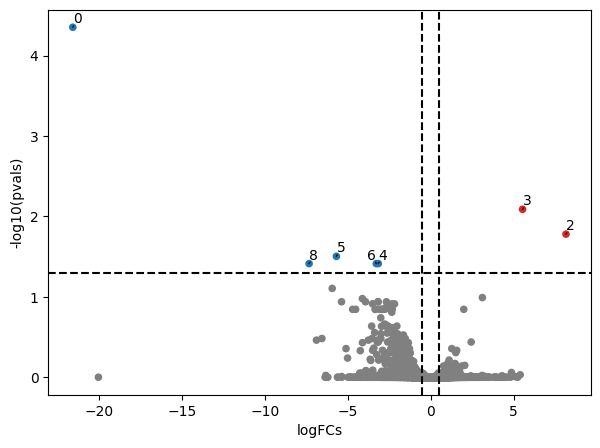

In [33]:
path = deseq_resdir + "/"+ "LUSC_vs_LUAD_B_cell_adata_DESeq2_result.tsv"
df = pd.read_csv(path,sep = "\t")
df = df.rename(columns={"gene_id":"GeneName"})
df.set_index(["GeneName"])
dc.plot_volcano_df(df, x='log2FoldChange', y='padj', top=20)

In [22]:
df

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,comparison
0,PTP4A1,57.534322,-21.562130,3.288572,-6.556684,5.501744e-11,0.000044,0.012214,LUSC_vs_LUAD
1,ADAT3,28.188902,-20.019252,3.289109,-6.086528,1.153857e-09,1.000000,0.000000,LUSC_vs_LUAD
2,GPX2,10.082700,8.160914,1.507618,5.413118,6.193666e-08,0.016587,0.012214,LUSC_vs_LUAD
3,MTRNR2L1,130.180434,5.544449,1.153652,4.805997,1.539818e-06,0.008140,0.928111,LUSC_vs_LUAD
4,UBE2S,272.570276,-3.152483,0.773286,-4.076737,4.567206e-05,0.038585,1.659363,LUSC_vs_LUAD
...,...,...,...,...,...,...,...,...,...
9829,RAD54L,4.191904,1.783942,2.142891,0.832493,NaN,NaN,NaN,LUSC_vs_LUAD
9830,RXRA,5.030309,1.537339,1.943421,0.791047,NaN,NaN,NaN,LUSC_vs_LUAD
9831,SCGB3A1,77.340325,6.673869,2.096078,3.183979,NaN,NaN,NaN,LUSC_vs_LUAD
9832,TMPRSS4,2.414175,4.901356,2.770289,1.769258,NaN,NaN,NaN,LUSC_vs_LUAD


In [13]:
def plot_paired(
    adata,
    groupby,
    *,
    paired_by=None,
    var_names=None,
    show=True,
    return_fig=False,
    n_cols=4,
    panel_size=(3, 4),
    show_legend=True,
    hue=None,
    size=10,
    ylabel="expression",
    pvalues: Sequence[float] = None,
    pvalue_template=lambda x: f"unadj. p={x:.2f}, t-test",
    adjust_fdr=False,
    boxplot_properties=None,
):
    """
    Pairwise expression plot.
    Makes on panel with a paired scatterplot for each variable.
    Parameters
    ----------
    adata
        adata matrix (usually pseudobulk).
    group_by
        Column containing the grouping. Must contain exactely two different values.
    paired_by
        Column indicating the pairing (e.g. "patient")
    var_names
        Only plot these variables. Default is to plot all
    """
    if boxplot_properties is None:
        boxplot_properties = {}
    groups = adata.obs[groupby].unique()
    if len(groups) != 2:
        raise ValueError(
            "The number of groups in the group_by column must be exactely 2"
        )

    if var_names is None:
        var_names = adata.var_names
        if len(var_names) > 20:
            warnings.warn(
                "You are plotting more than 20 variables which may be slow. "
                "Explicitly set the `var_names` paraloeter to turn this off. "
            )

    X = adata[:, var_names].X
    try:
        X = X.toarray()
    except AttributeError:
        pass

    groupby_cols = [groupby]
    if paired_by is not None:
        groupby_cols.insert(0, paired_by)
    if hue is not None:
        groupby_cols.insert(0, hue)

    df = adata.obs.loc[:, groupby_cols].join(
        pd.DataFrame(X, index=adata.obs_names, columns=var_names)
    )

    if paired_by is not None:
        # remove unpaired samples
        df[paired_by] = df[paired_by].astype(str)
        df.set_index(paired_by, inplace=True)
        has_matching_samples = df.groupby(paired_by).apply(
            lambda x: sorted(x[groupby]) == sorted(groups)
        )
        has_matching_samples = has_matching_samples.index[has_matching_samples].values
        removed_samples = adata.obs[paired_by].nunique() - len(has_matching_samples)
        if removed_samples:
            warnings.warn(f"{removed_samples} unpaired samples removed")

        # perform statistics (paired ttest)
        if pvalues is None:
            _, pvalues = scipy.stats.ttest_rel(
                df.loc[
                    df[groupby] == groups[0],
                    var_names,
                ].loc[has_matching_samples, :],
                df.loc[
                    df[groupby] == groups[1],
                    var_names,
                ].loc[has_matching_samples],
            )

        df = df.loc[has_matching_samples, :]
        df.reset_index(drop=False, inplace=True)

    else:
        if pvalues is None:
            _, pvalues = scipy.stats.ttest_ind(
                df.loc[
                    df[groupby] == groups[0],
                    var_names,
                ],
                df.loc[
                    df[groupby] == groups[1],
                    var_names,
                ],
            )

    if adjust_fdr:
        pvalues = statsmodels.stats.multitest.fdrcorrection(pvalues)[1]

    # transform data for seaborn
    df_melt = df.melt(
        id_vars=groupby_cols,
        var_name="var",
        value_name="val",
    )

    # start plotting
    n_panels = len(var_names)
    nrows = ceil(n_panels / n_cols)
    ncols = min(n_cols, n_panels)

    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(ncols * panel_size[0], nrows * panel_size[1]),
        tight_layout=True,
        squeeze=False,
    )
    axes = axes.flatten()
    if hue is None:
        hue = paired_by
    for i, (var, ax) in enumerate(zip_longest(var_names, axes)):
        if var is not None:
            sns.stripplot(
                x=groupby,
                data=df_melt.loc[lambda x: x["var"] == var],
                y="val",
                ax=ax,
                hue=hue,
                size=size,
                linewidth=1,
            )
            if paired_by is not None:
                sns.lineplot(
                    x=groupby,
                    data=df_melt.loc[lambda x: x["var"] == var],
                    hue=hue,
                    y="val",
                    ax=ax,
                    legend=False,
                    ci=None,
                )
            sns.boxplot(
                x=groupby,
                data=df_melt.loc[lambda x: x["var"] == var],
                y="val",
                ax=ax,
                color="white",
                fliersize=0,
                **boxplot_properties,
            )

            ax.set_xlabel("")
            ax.tick_params(
                axis="x",
                # rotation=0,
                labelsize=15,
            )
            ax.legend().set_visible(False)
            ax.set_ylabel(ylabel)
            ax.set_title(var + "\n" + pvalue_template(pvalues[i]))
        else:
            ax.set_visible(False)
    fig.tight_layout()

    if show_legend == True:
        axes[n_panels - 1].legend().set_visible(True)
        axes[n_panels - 1].legend(bbox_to_anchor=(1.1, 1.05))

    if show:
        plt.show()

    if return_fig:
        return fig